# MZI layout and simulation example
This example uses Jupyter Notebook as an environment.

# Generate MZI layout

* Import function packages

    Run the code cell and it will tell you the version of the ``FnPCell`` and ``GPDK``.

In [14]:
from dataclasses import dataclass
from fnpcell import all as fp
from gpdk import all as pdk
from gpdk.technology import get_technology 

* Create ``MMi1x2`` components in MZI

    Create ``Instanceset``, ``Elementset``, ``Portset`` for components and ports to add in the ``Device`` function in ``fnpcell``. Then call two ``Mmi1x2`` in ``pdk`` naming ``m1`` and ``m2``, repositioning their locations and instantiating to ``insts``. Users can add the script ``fp.plot()`` to display the components generated here.


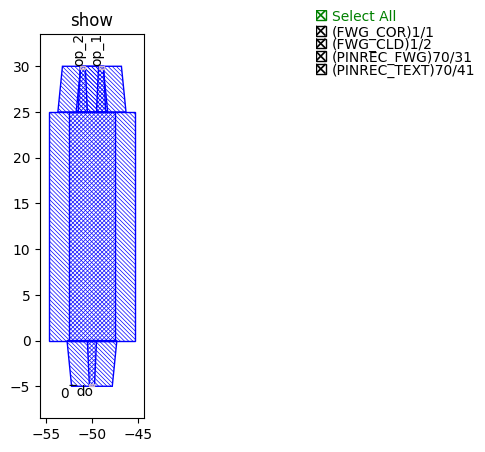

Mmi1x2(name='Mmi1x2', bands=None, patches=(), port_names=(), transform=Affine2D.new(scaling=(1.0, 1.0), rotation=1.5707963267948966, translation=(-50, 0)), _pcell_elapsed_time_=0.00669949999974051, mid_wav_core_width=5, wav_core_width=1, n_inputs=1, n_outputs=2, length=25, transition_length=5, trace_spacing=2, waveguide_type=WG.FWG.C._T_WIRE(core_layout_width=0.55, cladding_layout_width=4.45, core_design_width=0.45, cladding_design_width=4.45, port_names=('op_0', 'op_1')))

In [15]:
insts, elems, ports = fp.InstanceSet(), fp.ElementSet(), fp.PortSet()
mmi = pdk.Mmi1x2()
m1 = mmi.rotated(degrees=90).translated(-50, 0)
insts += m1
m2 = mmi.rotated(degrees=90).translated(50, 0)
insts += m2

fp.plot(m1)


* Create links and ports to connect ``MMI1x2`` in MZI

    The scripts here to generate links( ``fp.create_links`` ) and ports are the same when using Python IDE environment. However, in the end we have to create a cell reference which contains the ``instanceset``, ``elementset``, and ``portset`` we generated above. We can also plot the MZI device by using ``fp.plot`` function.

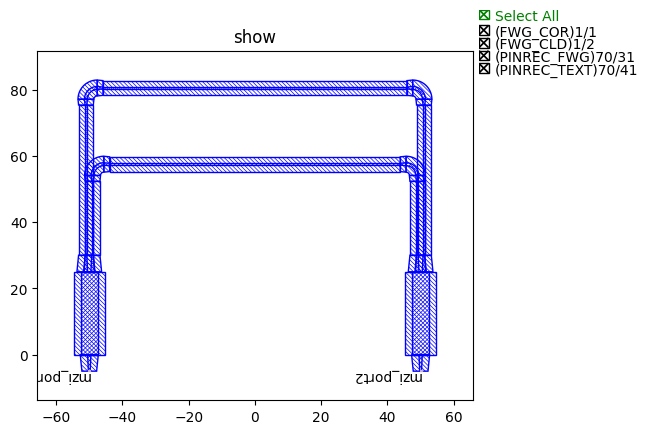

_ImmutableCellRef(assigned_cell=Cell(ports=(OwnedPort(name='mzi_port1', raw=OwnedPort(name='op_0', raw=OwnedPort(name='op_0', raw=Port(name='op_0', position=(-5, 0), orientation=3.141592653589793, waveguide_type=WG.FWG.C._T_WIRE(core_layout_width=0.55, cladding_layout_width=4.45, core_design_width=0.45, cladding_design_width=4.45, port_names=('op_0', 'op_1')), shape=Rect(width=0.3, height=0.55, corner_radii=(0, 0, 0, 0), transform=Affine2D.new(scaling=(1.0, 1.0), rotation=3.141592653589793, translation=(-4.85, 0.0))), hidden=False, disabled=False), assigned_orientation=None, hidden=False, disabled=False), assigned_orientation=None, hidden=False, disabled=False), assigned_orientation=None, hidden=False, disabled=False), OwnedPort(name='mzi_port2', raw=OwnedPort(name='op_0', raw=OwnedPort(name='op_0', raw=Port(name='op_0', position=(-5, 0), orientation=3.141592653589793, waveguide_type=WG.FWG.C._T_WIRE(core_layout_width=0.55, cladding_layout_width=4.45, core_design_width=0.45, cladding_d

In [16]:
TECH = get_technology()
links = fp.create_links(
            link_type=TECH.WG.FWG.C.WIRE,
            bend_factory=TECH.WG.FWG.C.EXPANDED.BEND_CIRCULAR,
            specs=[
                fp.LinkBetween(
                    m1["op_2"],
                    m2["op_1"],
                    target_length=200,
                ),
                fp.LinkBetween(
                    m1["op_1"],
                    m2["op_2"],
                    target_length=150
                ),
            ],
        )
insts += links
ports += m1["op_0"].with_name("mzi_port1")
ports += m2["op_0"].with_name("mzi_port2")

device = fp.Device(content=[insts], ports=ports)

fp.plot(device)

# MZI Post-layout simulation

* Import function package and export netlist(``.spc`` file)

    To run the post-simulation, we have to first define the environment of simulation. Note that in ``fp.sim.Env``, ``wl_start``, ``wl_end``, and ``points_num`` are necessary. Users are allowed to define some custom parameters, such as ``T`` or others.

    Then we export the netlist file by ``fp.export_spc``. ``device`` is the cell we generate above, which is the MZI circuit; ``file`` is the file location we want the netlist file to be export; ``components`` is all of the components we defined in **gpdk**; ``sim_env`` is the environment setting of the simulation.

In [18]:
import gpdk.components.all
components = gpdk.components.all
env = dict(wl_start=1.53, wl_end=1.565, points_num=351, T=300)
fp.export_spc(device, file="C:\\photoCAD\\layout1002\\local\\mzi_post_simulation.spc", components=components, sim_env=fp.sim.Env(**env))

export_spc: C:\photoCAD\layout1002\local\mzi_post_simulation.spc


Cell(ports=(OwnedPort(name='mzi_port1', raw=OwnedPort(name='op_0', raw=OwnedPort(name='op_0', raw=Port(name='op_0', position=(-5, 0), orientation=3.141592653589793, waveguide_type=WG.FWG.C._T_WIRE(core_layout_width=0.55, cladding_layout_width=4.45, core_design_width=0.45, cladding_design_width=4.45, port_names=('op_0', 'op_1')), shape=Rect(width=0.3, height=0.55, corner_radii=(0, 0, 0, 0), transform=Affine2D.new(scaling=(1.0, 1.0), rotation=3.141592653589793, translation=(-4.85, 0.0))), hidden=False, disabled=False), assigned_orientation=None, hidden=False, disabled=False), assigned_orientation=None, hidden=False, disabled=False), assigned_orientation=None, hidden=False, disabled=False), OwnedPort(name='mzi_port2', raw=OwnedPort(name='op_0', raw=OwnedPort(name='op_0', raw=Port(name='op_0', position=(-5, 0), orientation=3.141592653589793, waveguide_type=WG.FWG.C._T_WIRE(core_layout_width=0.55, cladding_layout_width=4.45, core_design_width=0.45, cladding_design_width=4.45, port_names=('o

* Run the simulation ``sflow``

    First we have to define the optical signal input and output port, then define the simulation environment and the netlist file we defined already.

In [20]:
import sflow as sf
sim_result = sf.run_sim(
        input_ports=["mzi_port1"],  
        output_ports=["mzi_port1", "mzi_port2"],  
        env=env,  
        netlist_file="C:\\photoCAD\\layout1002\\local\\mzi_post_simulation.spc", 
        is_print_netlist=True 
)


instances info:
Straight_4 <Straight>
TaperLinear_5 <TaperLinear>
BendCircular90_FWG_C_EXPANDED_3 <BendCircular90_FWG_C_EXPANDED>
TaperLinear_6 <TaperLinear>
Straight_5 <Straight>
TaperLinear_7 <TaperLinear>
BendCircular90_FWG_C_EXPANDED_4 <BendCircular90_FWG_C_EXPANDED>
TaperLinear_8 <TaperLinear>
Straight_6 <Straight>
Straight_1 <Straight>
TaperLinear_1 <TaperLinear>
BendCircular90_FWG_C_EXPANDED_1 <BendCircular90_FWG_C_EXPANDED>
TaperLinear_2 <TaperLinear>
Straight_2 <Straight>
TaperLinear_3 <TaperLinear>
BendCircular90_FWG_C_EXPANDED_2 <BendCircular90_FWG_C_EXPANDED>
TaperLinear_4 <TaperLinear>
Straight_3 <Straight>
Mmi1x2_1 <Mmi1x2>
Mmi1x2_2 <Mmi1x2>

links info:
Straight_4["op_1"]>>TaperLinear_5["op_0"]
TaperLinear_5["op_1"]>>BendCircular90_FWG_C_EXPANDED_3["op_0"]
BendCircular90_FWG_C_EXPANDED_3["op_1"]>>TaperLinear_6["op_0"]
TaperLinear_6["op_1"]>>Straight_5["op_0"]
Straight_5["op_1"]>>TaperLinear_7["op_0"]
TaperLinear_7["op_1"]>>BendCircular90_FWG_C_EXPANDED_4["op_0"]
BendCir

* Plot the simulation results

    Finally, we can plot the simulation results by importing ``matplot.pyplot``, the data are stored in ``sim_result``.

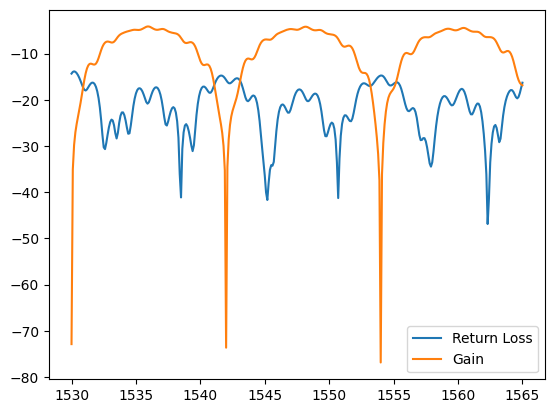

In [22]:
import matplotlib.pyplot as plt
return_loss = sim_result["mzi_port1"]
trans_gain = sim_result["mzi_port2"]

plt.plot(return_loss["wl"], return_loss["te_gain"], label="Return Loss")
plt.plot(trans_gain["wl"], trans_gain["te_gain"], label="Gain")
plt.legend()
plt.show()
